# [LAB-12] 1. 단순선형회귀

## #01. 회귀분석 개요

### 1. 회귀분석의 의미
- 변수 간 인과관계, 예측, 추론
- by f(x): y = a * x + b
- 회귀계수: a,b의 묶음
  - a, b: 독립변수가 종속변수에 미치는 영향
    - a: 가중치, b: 편향
  
로지스틱 '선형'회귀: 선형 관계면서 반응변수가 명목형(0 또는 1)일때!

## #02. 준비작업

### 1. 라이브러리 참조:

In [1]:
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# 선형회귀 객체(OLS, ordinary least squares) 참조
from statsmodels.formula.api import ols

# 상관분석용 참조
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기:

In [3]:
origin = load_data('cars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기: (50, 2)
열 갯수: 2
행 갯수: 50

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## #03. 탐색적 데이터 분석 단계


### 1. 관계 시각화 (by scatter(regplot)):
- 모든 EDA의 첫 단계는 산점도 그래프를 통한 시각화 부터임!

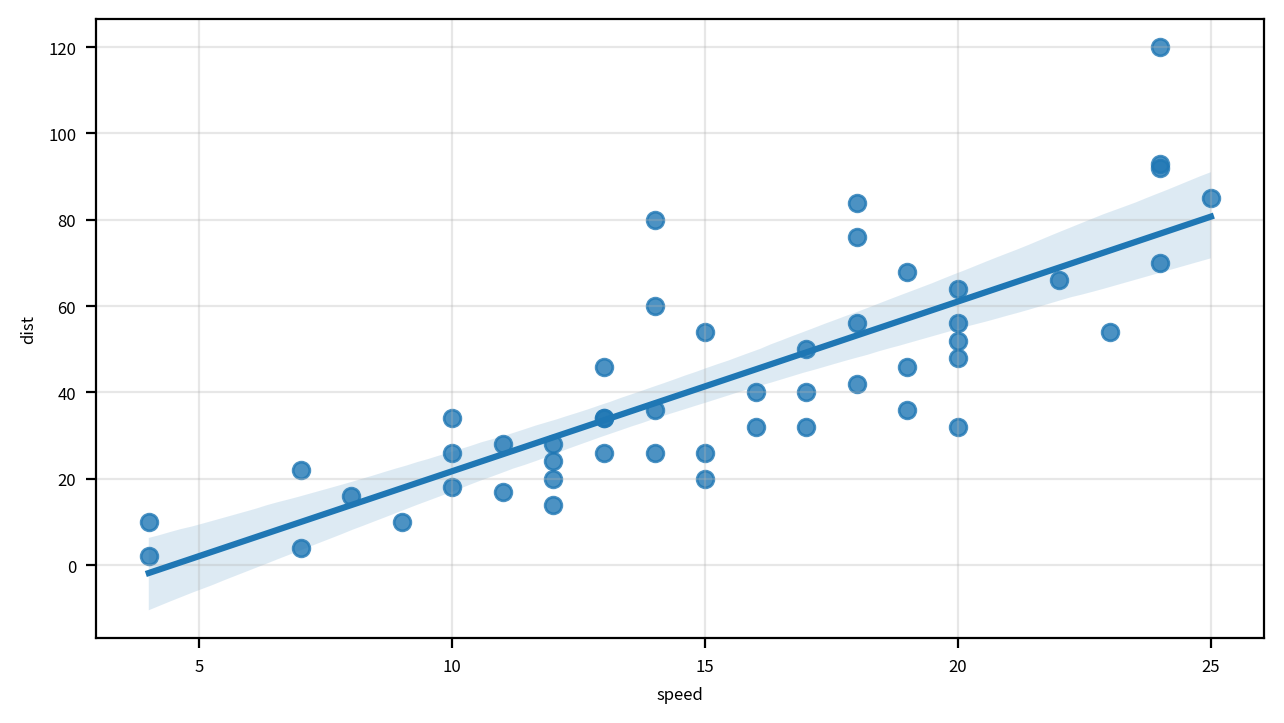

In [4]:
# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 산점도 그래프(Reg Plot) 그리기 (회귀선 포함)
    # regplot()은 hue 파라미터를 지원 안한다 ㅠ
sb.regplot(data = origin, x = 'speed', y = 'dist')

# 3) 그래프 꾸미기: 

ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

by 가시화: 양의 상관관계 눈대중으로 확인.

## #04. 추론통계 단계

### 1. 상관분석
- : 관계 존재 여부 확인
- 프로세스:
  1. 상관분석의 가정(선형성)
  2. 상관분석의 가정(이상치) 
  3. 상관분석 수행 
  4. 관계행렬 생성 
  5. 관계행렬 시각화


====== 이상치 확인 ======
이상치 존재 -> correlation coefficient: Spearman


,original_skew,log_skew,outliers(|z| > 3)
speed,-0.117510,-1.668586,0.0
dist,0.806895,-1.384501,1.0


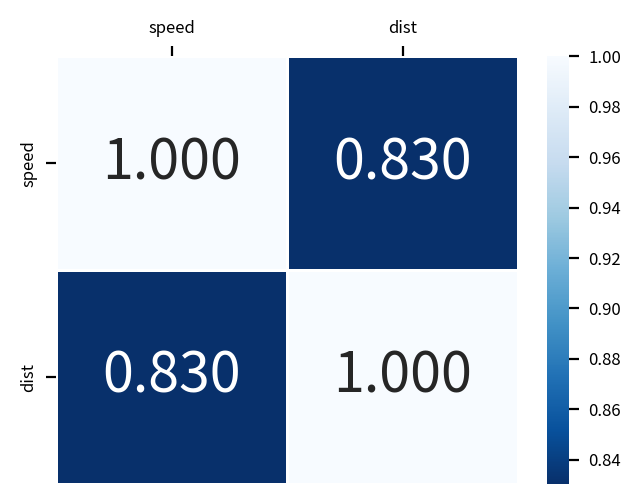

본 분석에서는 speed과 dist간 상관관계를 검토하였다.

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.830, p = 0.000(으)로 나타나 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [9]:
xname = 'speed'
yname = 'dist'

# ------------------------------------
# 선형성 가정 확인:
# ------------------------------------
# 1. 선형성: 산점도 그래프 시각화로 이미 확인함.
linearity_ok = True

# ------------------------------------
# 2. 이상치와 왜도:

data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산:
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3):
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그변환 후 왜도 계산 (음수 대비 +1):
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }

results_df = DataFrame(results).T

# 이상치 점검 결과:
outlier_flag = len(results_df['outliers(|z| > 3)'] > 0) > 0

print("\n====== 이상치 확인 ======")
print(f"{'이상치 존재 -> correlation coefficient: Spearman' if outlier_flag else '이상치 존재 X -> correlation coefficient: Pearson'}")
display(results_df)
# ------------------------------------
# 상관분석 수행
# ------------------------------------
report = f"본 분석에서는 {xname}과 {yname}간 상관관계를 검토하였다.\n\n"

# 상관계수 선택:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다.\n\n분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관" if corr > 0 else "음의 상관"} 관계가 함을 확인하였다."

else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])

    if pval > 0.05:
        report += "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
    else:
        report += f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.\n\n분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조" if corr > 0 else "음의 단조"} 관계가 존재함을 확인하였다."
    
# ------------------------------------
# 결과 시각화
# ------------------------------------
corr_matrix = origin[[xname, yname]].corr(method=chosen)

# 1) 그래프 초기화
width_px = 650              # 그래프 가로크기
height_px = 500             # 그래프 세로크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) Heatmap 그리기
sb.heatmap(data = corr_matrix, annot=True, fmt='0.3f', 
           linewidth = 0.5, cmap = "Blues_r", 
           annot_kws = {'size': 20})
  # camp: 칼라맵 종류: 'Greys', 'Purples', 'Blues', 'Greens', 
  # 'Oranges', 'Reds' / 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
  # 'RdPu', 'BuPu' / 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 
  # 'BuGn', 'YlGn' / 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 
  # 'RdBu', 'RdYlBu' / 'RdYlGn', 'Spectral', 'coolwarm', 
  # 'bwr', 'seismic' / 'berlin', 'managua', 'vanimo'

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()        # x축 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료

# ------------------------------------
# 결과 보고 출력
# ------------------------------------
print(report)

### 2. 회귀분석(단순선형회귀)
- : 수식화로 정략적 관계 규명 및 예측

#### by: Method 1) 행렬기반 방식
- why 행렬? 추후 나올 ML 코드와 스타일 유사
  - 실무적합성 및 대규모 처리
- 이 행렬기반 방식 추천함
- drawback: 상수항(디폴트=1) 추가 과정 필요

**1. 독립변수 행렬 준비:**

In [10]:
x = origin[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


**2. 종속변수 Series 형태 준비:**

In [11]:
y = origin['dist']
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

**3. 상수항 추가:**

In [12]:
X = sm.add_constant(x)
X.head()

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8


**4. 회귀분석 수행:**

In [13]:
# OLS 모델 객체 생성
# -> 이 단계에선 학습(fit)전 '모델의 틀'만 만들어짐
model = sm.OLS(y, X)

# 모델 적합(Fit)
# -> 데이터와 객체 기능 이용해서 회귀계수(β) 추정하고, 모델을 완성시키는 단계
fit = model.fit()

# 적합된 모델 객체의 분석 결과 확인:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        11:18:13   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

#### Method 2) formula API 방식
- 장점: 상수항은 자동 추가됨, 따로 추가하는 과정 필요 ㄴㄴ
- drawback: 모델 객체 생성을 '문자열'로 하기 때문에(≒R 방식) 오타 나면 귀찮아짐

In [14]:
# 학습 모델 객체 생성
model = ols("dist ~ speed", data=origin)

# 모델 적합(Fit)
fit = model.fit()

# 분석 결과 확인:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        11:20:35   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

## #05. 결과표 해석방법

### 1. 모형적합도 설명변수(1~6):
- 1. **r-squared**: 설명력(잔차제곱, 선형회귀 모델에서는 60% 이상 나오면 적합하다고 판단)
- 4. **Prob (F-statistic)**: f통계량의 p-value (유의수준)
- 5. log-likelihood: 값 크면 클수록 적합
- 6. AIC/BIC: 값 작으면 작을수록 적합
  
### 2. **회귀계수(7~8)**: 회귀분석의 목적
- 7. 편향(절편): $\beta_0$
- 8. 기울기(가중치): $\beta_1$, $\beta_2$, ...
  
- 9. P > |t|: 각 7,8에 대한 유의수준(p-value)
  - if 'P>|t|' > 0.05인 변수 n개 나온 결과표가 나오면!
  - 유의수준 맞추기 위해 변수 n개 각각 하나씩 빼보는 과정, 총 n번 돌리면서 바뀌는 'P>|t|'값 0.05보다 작아지는지 확인하기

## #06. 회귀분석 결과 보고 
보고 형식, 과정 체득하기!

## #07. 실제데이터랑 예측값(y_pred) 비교
- 잔차 적을수록, 즉 실제데이터랑 예측값 간 일치률이 높을수록 모형 적합성 굳
- '선형회귀의 가정'이 나중에 사후검정으로 들어간다

### 1. 모형 예측값 얻기:

In [15]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [16]:
df_melt = df.melt(
    id_vars = "speed",
    value_vars = ['dist', 'y_pred'],
    var_name = 'variable',
    value_name = 'value'
)

df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


### 2. 시각화 비교:

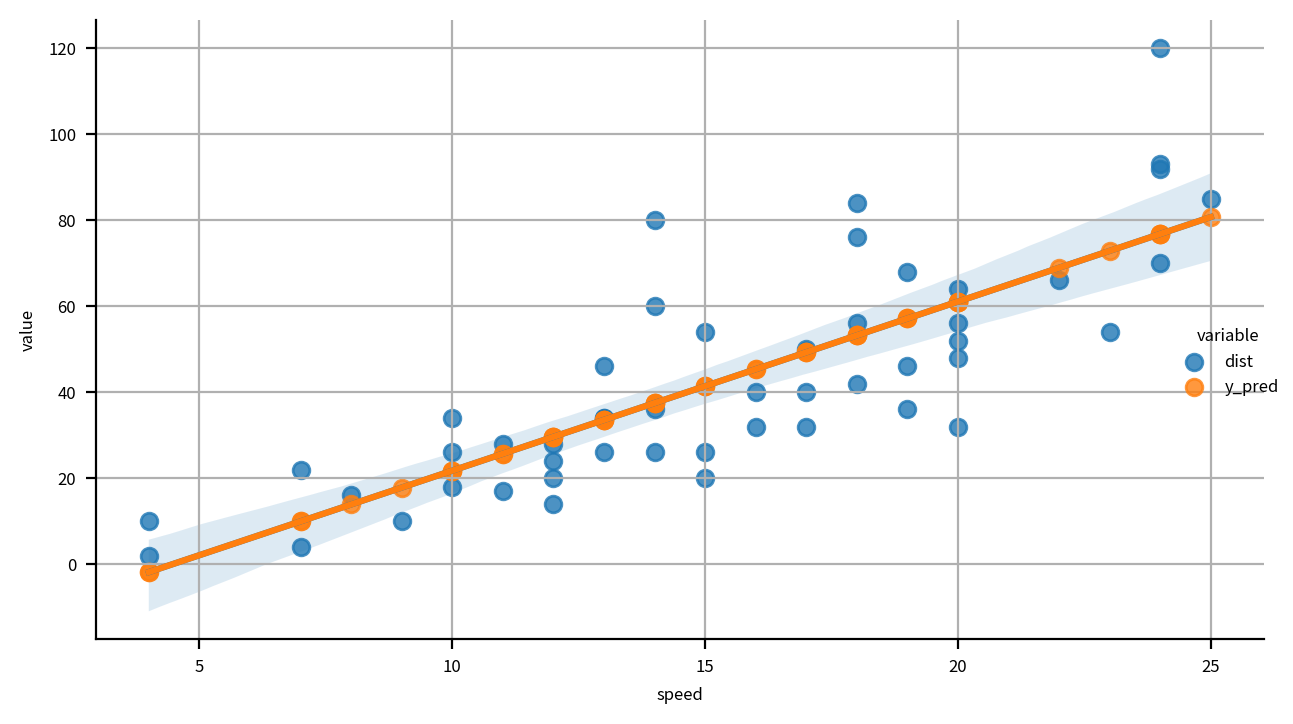

In [17]:
# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) Lm Plot 그래프 그리기
# 하위 집단이 여러개 이므로 그래프 꾸미기가 필요
    # -> .lmplot() 메서드로부터 리턴되는 객체 ('g')를 활용해야함

# 한 그래프 안에 다 넣어서 보고자 할 때:
g = sb.lmplot(data = df_melt, hue = 'variable', x = 'speed', y = 'value')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])
plt.grid()

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료